In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tkinter import filedialog
from scipy.optimize import curve_fit
from scipy import integrate

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from scipy.special import voigt_profile

def find_and_fit_peaks(wavelength, intensity, 
                       savgol_window=11, savgol_polyorder=3, 
                       peak_height_ratio=0.1, peak_distance=10):
    """
    IRスペクトルから二次微分でピークを検出し、フォークト関数でフィッティングする関数。

    Args:
        wavelength (np.ndarray): 波長・波数データ (x軸)
        intensity (np.ndarray): 吸光度・強度データ (y軸)
        savgol_window (int): Savitzky-Golayフィルタのウィンドウサイズ（奇数）。
                             スペクトルのピーク幅に応じて調整します。
        savgol_polyorder (int): Savitzky-Golayフィルタの多項式次数。通常は2か3。
        peak_height_ratio (float): ピーク検出の高さの閾値。二次微分スペクトルの
                                   最大値に対する割合で指定します。
        peak_distance (int): 検出されるピーク間の最小距離（データ点数）。

    Returns:
        tuple: 以下の2つの要素を含むタプル。
            - np.ndarray: 各ピークのフィッティング係数 (amplitude, center, sigma, gamma) 
                          の配列。形状は (num_peaks, 4)。
            - dict: curve_fitから返される最適化パラメータ(popt)と共分散行列(pcov)を
                    含む辞書。フィッティング曲線を描画する際に使用します。
            ピークが検出されなかった場合やフィッティングに失敗した場合は (None, None) を返します。
    """

    # --- Step 1: 二次微分の計算 ---
    # Savitzky-Golayフィルタで平滑化と二次微分を同時に行い、ノイズの影響を低減
    try:
        second_derivative = savgol_filter(intensity, 
                                          window_length=savgol_window,
                                          polyorder=savgol_polyorder, 
                                          deriv=2)
    except ValueError as e:
        print(f"Error in savgol_filter: {e}")
        print("`savgol_window`は奇数で、`savgol_polyorder`より大きい必要があります。")
        return None, None

    # --- Step 2: ピーク位置の特定 ---
    # 二次微分スペクトルでは、元のピークは負の谷（極小値）として現れる。
    # そのため、-1を掛けて正のピークとして検出しやすくする。
    min_peak_height = np.max(-second_derivative) * peak_height_ratio
    peak_indices, _ = find_peaks(-second_derivative, 
                                 height=min_peak_height, 
                                 distance=peak_distance)

    if len(peak_indices) == 0:
        print("警告: ピークが見つかりませんでした。パラメータを調整してください。")
        return None, None
    
    num_peaks = len(peak_indices)
    print(f"二次微分により {num_peaks} 個のピークが検出されました。")

    # --- Step 3: フォークト関数モデルの定義 ---
    # 1つのピークに対するフォークト関数
    def voigt(x, amplitude, center, sigma, gamma):
        # sigma: ガウス関数の標準偏差, gamma: ローレンツ関数の半値幅
        return amplitude * voigt_profile(x - center, sigma, gamma)

    # 複数のピークの和を表す関数
    def multi_voigt(x, *params):
        y = np.zeros_like(x, dtype=float)
        for i in range(num_peaks):
            # パラメータをアンパック
            amp = params[i * 4]
            cen = params[i * 4 + 1]
            sig = params[i * 4 + 2]
            gam = params[i * 4 + 3]
            y += voigt(x, amp, cen, sig, gam)
        return y

    # --- Step 4: フィッティングの初期値設定 ---
    initial_params = []
    # 検出されたピーク位置から、各パラメータの初期値を設定
    for i in peak_indices:
        amplitude = intensity[i]
        center = wavelength[i]
        # 幅 (sigma, gamma) は経験的な初期値。データに応じて調整が必要な場合がある。
        sigma = 5.0 
        gamma = 5.0
        initial_params.extend([amplitude, center, sigma, gamma])
        
    # パラメータの境界条件（すべて非負）
    bounds = (0, np.inf)

    # --- Step 5: カーブフィッティングの実行 ---
    try:
        popt, pcov = curve_fit(
            multi_voigt,
            wavelength,
            intensity,
            p0=initial_params,
            bounds=bounds
        )
    except RuntimeError as e:
        print(f"フィッティングに失敗しました: {e}")
        return None, None
    except ValueError as e:
        print(f"フィッティングの入力値に問題があります: {e}")
        return None, None

    # --- Step 6: 結果の整形 ---
    # 最適化されたパラメータをピークごとにまとめる
    fit_params = np.reshape(popt, (num_peaks, 4))
    
    return fit_params, {"popt": popt, "pcov": pcov}



In [4]:


def voigt(x, amplitude, center, sigma, gamma):
    """
    フォークト関数を計算する関数。
    x: 波長・波数データ
    amplitude: ピークの振幅
    center: ピークの中心位置
    sigma: ガウス関数の標準偏差
    gamma: ローレンツ関数の半値幅
    """
    return amplitude * voigt_profile(x - center, sigma, gamma)

def multiple_voigt(x, *params):
    """
    複数のフォークト関数を合成する関数。
    各ピークのパラメータは (amplitude, center, sigma, gamma) の順で与えられる。
    """
    y = np.zeros_like(x, dtype=float)
    num_peaks = len(params) // 4
    for i in range(num_peaks):
        amp = params[i * 4]
        cen = params[i * 4 + 1]
        sig = params[i * 4 + 2]
        gam = params[i * 4 + 3]
        y += voigt(x, amp, cen, sig, gam)
    return y

In [18]:
paths = filedialog.askopenfilenames()

In [14]:
import os
re_paths = []
for path in paths:
    no = path.split("/")[-1].split("-")[0]
    if no == '2':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)
    elif no == '3':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C1min_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path) 
    elif no == '4':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C3min_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)
    elif no == '5':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C5min_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)
    elif no == '6':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C10min_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)
    elif no == '7':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C30min_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)
    elif no == '8':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C1h_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)
    elif no == '9':
        re_path = path.replace('-', '_').replace('.txt', '_EP_80C2h180C3h_20250909.txt')
        os.rename(path, re_path)
        re_paths.append(re_path)

FileNotFoundError: [WinError 2] 指定されたファイルが見つかりません。: '9' -> '9'

In [13]:
paths = re_path

In [15]:
%matplotlib tk

In [8]:
result = {}

In [9]:
colors = {
    '1': 'red',
    '2': 'blue',
    '3': 'green',
    '4': 'orange',
    '5': 'purple',
    '6': 'brown',
    '7': 'pink',
    '8': 'yellow',
    '9': 'gray',
    '10': 'cyan',
    }

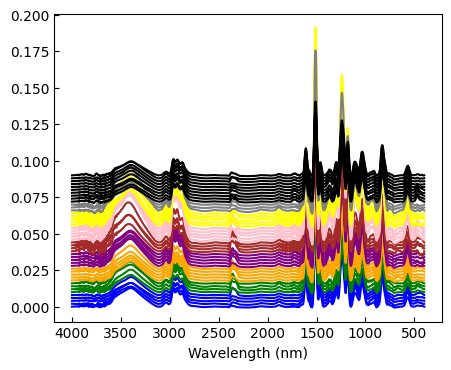

In [20]:
# 全体データの確認
fig, ax = plt.subplots(figsize=(5, 4))
for i, path in enumerate(paths):
    with open(path, 'r') as f:
        lines = f.readlines()
        lines = lines[4:]
        lines = [line.strip().replace('\\n', '').split() for line in lines if line.strip()]

    xx = [float(lines[i][0]) for i in range(len(lines))]
    yy = [float(lines[i][1]) for i in range(len(lines))]
    yy = [y / max(yy) for y in yy]

    # ベンゼンピークによる補正
    xx_range = [x for x in xx if 1480 <= x <= 1540]
    yy_range = [yy[i] for i, x in enumerate(xx) if 1480 <= x <= 1540]
    xx_fit = [xx_range[i] for i, x in enumerate(yy_range) if x > 0.5]
    yy_fit = [yy_range[i] for i, x in enumerate(yy_range) if x > 0.5]

    popt, _ = curve_fit(voigt, xx_fit, yy_fit, p0=[20, 1510, 10, 1])
    # R2による確認
    R2 = 1 - np.sum((yy_fit - voigt(np.array(xx_fit), *popt))**2) / np.sum((yy_fit - np.mean(yy_fit))**2)
    if R2 < 0.98:
        print(f"Warning: Low R2 value ({R2:.2f}) for file {path}. Check the fit quality.")
        print(f"Parameters: {popt}")
        
    area = integrate.simps(voigt(np.array(xx), *popt), xx)
    yy = [y / area for y in yy]  # 面積を1に正規化

    yy = [y + 0.002 * i for y in yy]
    label = path.split('/')[-1].split('.')[0]
    no = label.split('_')[0]
    color = colors.get(no, 'black')

    ax.plot(xx, yy, label=label, color=color)
    result[path] = {'area': area}

ax.set_xlabel('Wavelength (nm)')
# ax.axvline(x=1510, color='black', linestyle='--', label='1510 nm')
ax.invert_xaxis()

# plt.savefig(filedialog.asksaveasfilename(defaultextension='.svg', filetypes=[('SVG files', '*.svg')]))
plt.show()


In [10]:
for i, x in enumerate(xx):
    if x > 915:
        print(i)
        break

for i, x in enumerate(xx):
    if x > 1510:
        print(i)
        break

268
576


In [21]:
def peak_range(xx, yy, peak):
    peak_index = next(i for i, x in enumerate(xx) if x > peak)
    fy_1 = np.gradient(yy)
    fy_2 = np.gradient(fy_1)
    

In [38]:
paths = filedialog.askopenfilenames()

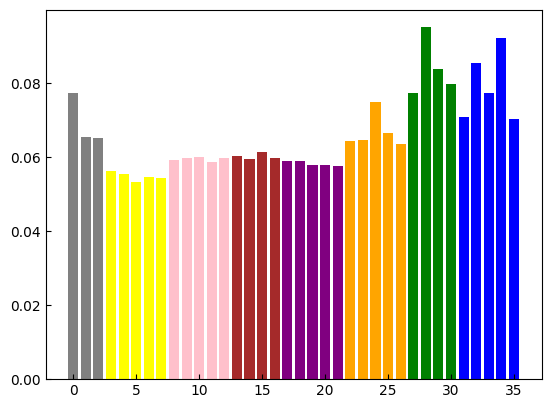

In [39]:
intensities = {'2':[], '3':[], '4':[], '5':[], '6':[], '7':[], '8':[], '9':[], '10':[], 'x':[]}
for i, path in enumerate(paths):
    with open(path, 'r') as f:
        lines = f.readlines()
        lines = lines[4:]
        lines = [line.strip().replace('\\n', '').split() for line in lines if line.strip()]

    xx = [float(lines[i][0]) for i in range(len(lines))]
    yy = [float(lines[i][1]) for i in range(len(lines))]
    yy = np.array([y / max(yy) for y in yy])

    xx_index_915 = next(i for i, x in enumerate(xx) if x > 915)
    xx_index_1510 = next(i for i, x in enumerate(xx) if x > 1510)
    A1510 = yy[xx_index_1510]
    A915 = yy[xx_index_915]
    # print(f': A1510 = {A1510}, A915 = {A915}, Ratio = {A1510 / A915}')
    plt.bar(i, A915 / A1510, color=colors.get(path.split('/')[-1].split('_')[0], 'black'), label=path.split('/')[-1].split('.')[0])
    # plt.plot(xx[xx_index_915:xx_index_1510], yy[xx_index_915:xx_index_1510] + 0.1*i, color=colors.get(path.split('/')[-1].split('_')[0], 'black'))
    intensities[path.split('/')[-1].split('_')[0]].append(A915 / A1510)

In [ ]:
init_int = np.average(intensities['x'])
finally_int = np.average(intensities['9'])


c:\Users\uttya\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\uttya\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


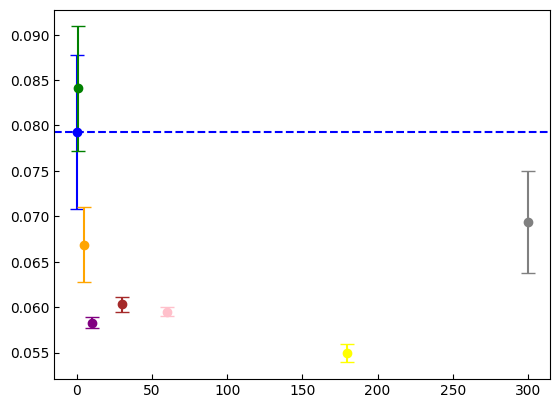

In [ ]:
time = [0, 1, 5, 10, 30, 60, 180, 300]
time = {'2':0, '3':1, '4':5, '5':10, '6':30, '7':60, '8':180, '9':300, 'x':-10}
for i, (key, vals) in enumerate(intensities.items()):
    if len(vals) == 0:
        continue
    val_avg = sum(vals) / len(vals)
    val_std = (sum((v - val_avg) ** 2 for v in vals) / len(vals)) ** 0.5
    
    if key == '2':
        plt.axhline(val_avg, color=colors.get(key, 'black'), linestyle='--')

    if key == 'x':
        continue
    plt.errorbar(time[key], val_avg, yerr=val_std, color=colors.get(key, 'black'), capsize=5, fmt='o',)

# plt.xlim(0, 310)
plt.save

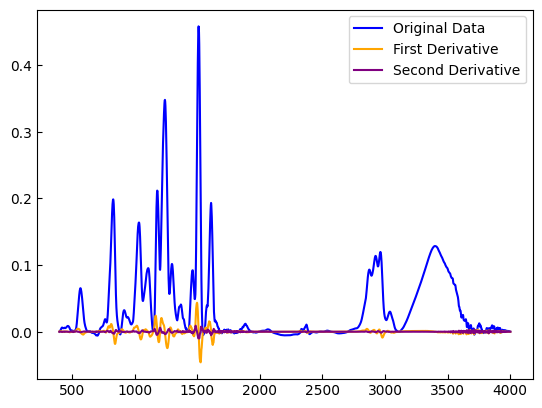

In [16]:
path = paths[0]
with open(path, 'r') as f:
    lines = f.readlines()
    lines = lines[4:]
    lines = [line.strip().replace('\\n', '').split() for line in lines if line.strip()]

xx = [float(lines[i][0]) for i in range(len(lines))]
yy = [float(lines[i][1]) for i in range(len(lines))]
fy_1 = np.gradient(yy)
fy_2 = np.gradient(fy_1)

plt.plot(xx, yy, label='Original Data', color='blue')
plt.plot(xx, fy_1, label='First Derivative', color='orange')
plt.plot(xx, fy_2, label='Second Derivative', color='purple')
plt.legend()

In [ ]:
plt.axhline(y=0, color='black', linestyle='--')

In [19]:
def find_and_fit_peaks_no_smoothing(wavelength, intensity, 
                                     peak_height_ratio=0.1, peak_distance=10):
    """
    【平滑化なし版】
    スペクトルから二次微分でピークを検出し、フォークト関数でフィッティングする関数。

    Args:
        wavelength (np.ndarray): 波長・波数データ (x軸)
        intensity (np.ndarray): 吸光度・強度データ (y軸)
        peak_height_ratio (float): ピーク検出の高さの閾値。二次微分スペクトルの
                                   最大値に対する割合で指定します。
        peak_distance (int): 検出されるピーク間の最小距離（データ点数）。

    Returns:
        tuple: 以下の2つの要素を含むタプル。
            - np.ndarray: 各ピークのフィッティング係数 (amplitude, center, sigma, gamma) 
                          の配列。形状は (num_peaks, 4)。
            - dict: curve_fitから返される最適化パラメータ(popt)と共分散行列(pcov)を
                    含む辞書。
            ピークが検出されなかった場合やフィッティングに失敗した場合は (None, None) を返します。
    """

    # --- Step 1: 二次微分の計算 (平滑化なし) ---
    # numpy.gradientを2回適用して二次微分を計算する
    first_derivative = np.gradient(intensity, wavelength)
    second_derivative = np.gradient(first_derivative, wavelength)

    # --- Step 2: ピーク位置の特定 ---
    # 二次微分スペクトルでは、元のピークは負の谷になるため、-1を掛けてfind_peaksに渡す
    min_peak_height = np.max(-second_derivative) * peak_height_ratio
    peak_indices, _ = find_peaks(-second_derivative, 
                                 height=min_peak_height, 
                                 distance=peak_distance)

    if len(peak_indices) == 0:
        print("警告: ピークが見つかりませんでした。パラメータを調整してください。")
        return None, None
    
    num_peaks = len(peak_indices)
    print(f"二次微分により {num_peaks} 個のピークが検出されました。")

    # --- Step 3, 4, 5 (フィッティング部分は変更なし) ---
    def voigt(x, amplitude, center, sigma, gamma):
        return amplitude * voigt_profile(x - center, sigma, gamma)

    def multi_voigt(x, *params):
        y = np.zeros_like(x, dtype=float)
        for i in range(num_peaks):
            amp, cen, sig, gam = params[i*4], params[i*4+1], params[i*4+2], params[i*4+3]
            y += voigt(x, amp, cen, sig, gam)
        return y

    initial_params = []
    for i in peak_indices:
        initial_params.extend([intensity[i], wavelength[i], 5.0, 5.0])
        
    bounds = (0, np.inf)

    try:
        popt, pcov = curve_fit(multi_voigt, wavelength, intensity, p0=initial_params, bounds=bounds)
    except (RuntimeError, ValueError) as e:
        print(f"フィッティングに失敗しました: {e}")
        return None, None

    fit_params = np.reshape(popt, (num_peaks, 4))
    
    return fit_params, {"popt": popt, "pcov": pcov}



In [110]:
%matplotlib inline

In [34]:
j = 0
fig, ax = plt.subplots(figsize=(5, 4))
for i, path in enumerate(paths):
    with open(path, 'r') as f:
        lines = f.readlines()
        lines = lines[4:]
        lines = [line.strip().replace('\\n', '').split() for line in lines if line.strip()]

    xx = [float(lines[i][0]) for i in range(len(lines))]
    yy = [float(lines[i][1]) for i in range(len(lines))]
    yy = [y / max(yy) for y in yy]

    xx_need = [x for x in xx if 880 < x < 970]
    yy_need = [yy[i] for i, x in enumerate(xx) if 880 < x < 970]
    # fit_params, fit_info = find_and_fit_peaks_no_smoothing(
    #     np.array(xx_need), np.array(yy_need), 
    #     peak_height_ratio=0.000001, 
    #     peak_distance=1
    #     )
    
    # if fit_params is not None:
    #     plt.plot(xx_need, yy_need, 'o', color='gray', markersize=4, label='Original Data')
    #     plt.plot(xx_need, multiple_voigt(np.array(xx_need), *fit_info['popt']), 'r-', linewidth=2.5, label='Total Fit')
    #     for i, params in enumerate(fit_params):
    #         peak = params[0] * voigt_profile(np.array(xx_need) - params[1], params[2], params[3])
    #         plt.plot(xx_need, peak, '--', label=f'Separated Peak {i+1}')
    # plt.legend()
    # plt.show()
    if path.split('/')[-1].split('_')[1] == '2' or path.split('/')[-1].split('_')[0] == 'x':
        no = path.split('/')[-1].split('_')[0]
        color = colors.get(no, 'black')
        plt.plot(xx_need, np.array(yy_need) + 0.05 * j, 
                label=path.split('/')[-1].split('.')[0], 
                color=color, linewidth=1.5)
        j += 1

plt.xlabel('Wavelength (nm)')
ax.invert_xaxis()
plt.xlim(970, 880)

    # 915nmのピークの面積を計算
    # popt = fit_params[0]
    # for params in fit_params:
    #     if abs(params[1] - 915) < abs(popt[1] - 915):
    #         popt = params

    # area = integrate.simps(voigt(np.array(xx), *popt), xx)
    # print(f"File: {path}, Area: {area}")
    # result[path]['915area'] = area

    # break

(970.0, 880.0)

In [36]:
def fit_manual_peaks(wavelength, intensity, initial_guesses):
    """手動で指定した初期値でフィッティングする関数"""
    num_peaks = len(initial_guesses)
    print(f"手動で {num_peaks} 個のピークをフィッティングします。")
    
    # 複数のVoigt関数の和
    def multi_voigt(x, *params):
        y = np.zeros_like(x, dtype=float)
        for i in range(num_peaks):
            amp, cen, sig, gam = params[i*4], params[i*4+1], params[i*4+2], params[i*4+3]
            y += amp * voigt_profile(x - cen, sig, gam)
        return y

    # 初期値をフラットなリストに変換
    initial_params = [p for guess in initial_guesses for p in guess]

    try:
        popt, pcov = curve_fit(multi_voigt, wavelength, intensity, p0=initial_params, bounds=(0, np.inf), maxfev=10000)
    except (RuntimeError, ValueError) as e:
        print(f"フィッティングに失敗しました: {e}")
        return None, None

    fit_params = np.reshape(popt, (num_peaks, 4))
    return fit_params, {"popt": popt, "pcov": pcov}

In [ ]:
colors = {2: 'red', 9: 'blue', 12: 'green', 19: 'orange'}

In [85]:
for i, path in enumerate(paths):
    with open(path, 'r') as f:
        lines = f.readlines()
        lines = lines[4:]
        lines = [line.strip().replace('\\n', '').split() for line in lines if line.strip()]

    xx = [float(lines[i][0]) for i in range(len(lines))]
    yy = [float(lines[i][1]) for i in range(len(lines))]
    yy = [y / max(yy) for y in yy]

    xx_need = [x for x in xx if 880 < x < 990]
    yy_need = [yy[i] for i, x in enumerate(xx) if 880 < x < 990]
    # yy_need = [y / max(yy_need) for y in yy_need]
    initial_guesses = [[0.07, 912, 5, 5],
                       [0.07, 937, 5, 5],
                        [0.07, 956, 5, 5],
                         [0.07, 990, 5, 5]]
    fit_params, fit_info = fit_manual_peaks(
        np.array(xx_need), np.array(yy_need),
        initial_guesses
        )
    if fit_params is not None:
        no = int(path.split('/')[-1].split('_')[0])
        color = colors.get(no, 'black')
        plt.plot(xx_need, np.array(yy_need), color=color, markersize=4, label='Original Data')
        # plt.plot(xx_need, 0.01 * i + multiple_voigt(np.array(xx_need), *fit_info['popt']), 'r-', linewidth=2.5, label='Total Fit')
        # for j, params in enumerate(fit_params):
        #     peak = params[0] * voigt_profile(np.array(xx_need) - params[1], params[2], params[3])
        #     plt.plot(xx_need, 0.01 * i + peak, '--', label=f'Separated Peak {j+1}')
    plt.show()



手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。
手動で 4 個のピークをフィッティングします。


In [35]:
rate = {'2': [], '9': [], '12': [], '19': [], 'x': []}
for key, values in result.items():
    print(f"Key: {key}, Values: {values}")
    no = key.split('/')[-1].split('_')[0]
    r = values['915area'] / values['area']
    rate[no] += [r]
    plt.bar(key, r, color=colors.get(no, 'black'), label=no)

Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/2_1_EP_80C2h_20250718.txt, Values: {'area': 22.14456274431088, '915area': 1.3076317132981174}
Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/2_2_EP_80C2h_20250718.txt, Values: {'area': 20.401778428274916, '915area': 1.3353385228226715}
Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/2_3_EP_80C2h_20250718.txt, Values: {'area': 18.90547927765852, '915area': 1.301139549854435}
Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/2_4_EP_80C2h_20250718.txt, Values: {'area': 18.461081814662304, '915area': 1.3819609286035923}
Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/2_5_EP_80C2h_20250718.txt, Values: {'area': 34.19646307715655, '915area': 1.6518868504575517}
Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/9_1_EP_80C2h180C5h_20250718.txt, Values: {'area': 31.797869635880556, '915area': 1.259687647753509}
Key: C:/Users/uttya/OneDrive/神戸大学/西野研/00_reserch/解析データ/10_IR/9_

In [40]:
rate0 = rate['x'][0]
for key, values in rate.items():
    v = np.mean(values)
    v_std = np.std(values)
    plt.bar(key, v, yerr=v_std, color=colors.get(key, 'black'), label=key)
    convert = (1 - v / rate0) * 100
    print(f"{key}: {v:.3f} ± {v_std:.3f} (Converted: {convert:.3f})")


2: 0.063 ± 0.009 (Converted: 62.901)
9: 0.048 ± 0.006 (Converted: 71.852)
12: 0.067 ± 0.013 (Converted: 61.017)
19: 0.046 ± 0.007 (Converted: 73.257)
x: 0.171 ± 0.000 (Converted: 0.000)
